In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import h5py 
import datetime
import glob
import copy
from calendar import monthrange
from cartopy.io.shapereader import Reader
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,
                                LatitudeLocator)

In [2]:
def compilealldatatarget(lats,lons,filelist,footprintradio,targetname1,targetname2):
    
    minlat = (min(lats)-footprintradio/110.0)
    maxlat = (max(lats)+footprintradio/110.0)
    minlon = (min(lons)-footprintradio/110.0)
    maxlon = (max(lons)+footprintradio/110.0)
    
    ilats = np.arange(int(maxlat)-int(minlat)+1,dtype=int)+int(minlat)
    ilons = np.arange(int(maxlon)-int(minlon)+1,dtype=int)+int(minlon)


    for ifile,filename in enumerate(filelist):
        datos = h5py.File(filename,'r')
        #print(ifile)
        for lat in ilats:
            for lon in ilons:
                #print(lat,lon)
                try:
                    gridname = '%iN%iW' % (lat,lon)
                    #print(gridname)
                    lt = datos[gridname]['lat'][()]
                    ln = datos[gridname]['lon'][()]
                    #print(ln)
                    tid = datos[gridname]['/Sounding/target_id'][()] 
                    tname = datos[gridname]['/Sounding/target_name'][()]
                    tidstr = tid.astype('U')
                    tnamestr = tname.astype('U')
                    mask = ((lt <= maxlat) & (lt >= minlat) & \
                           (ln <= maxlon) & (ln >= minlon) & \
                           ((tidstr == targetname1) | (tidstr == targetname2)))
                    #print(mask)
                    data_inter = datos[gridname][mask]
                    #print(data_inter)
                    
                    try:
                        data = np.append(data,data_inter)
                        #print('matrix exists')
                    except:
                        data = copy.copy(data_inter)
                        #print(data)
                        #print('new matrix')
                    print(data.shape)
                except:
                    print('exception: no dataset')
                #print 'data:',len(data)
                #print max(data['lat']), min(data['lat']), max(data['lon']), min(data['lon'])

        datos.close()
    #plt.plot(data['lon'],data['lat'],'.')
    #plt.show()
    return data


In [3]:
def datacorrection_ml(dset,data,corrtype):
    
    cont = 0
    t0 = datetime.datetime.utcfromtimestamp(0.0)
    datacorr = copy.copy(data)
    print(data[name])
    for ii,ele in enumerate(dset['year']):
        
        try:
            tmin = (datetime.datetime(year=dset['year'][ii],month=dset['month'][ii],day=dset['day'][ii]-1,hour=0,minute=0,second=0)-t0).total_seconds()
        except:
            maxdays = monthrange(dset['year'][ii],dset['month'][ii]-1)
            tmin = (datetime.datetime(year=dset['year'][ii],month=dset['month'][ii]-1,day=monthrange,hour=0,minute=0,second=0)-t0).total_seconds()
        try:
            tmax = (datetime.datetime(year=dset['year'][ii],month=dset['month'][ii],day=dset['day'][ii]+1,hour=23,minute=59,second=59)-t0).total_seconds() 
        except:
            tmax = (datetime.datetime(year=dset['year'][ii],month=dset['month'][ii]+1,day=1,hour=23,minute=59,second=59)-t0).total_seconds()
        
        mask = (tmin <= data['tepoch']) & (tmax >= data['tepoch'])
        
        if corrtype == 0:
            datacorr[name][mask] = (data[name][mask]*data[psurf][mask] - dset['xCO2altz'][ii]*dset['psurfaltz'][ii])/(data[psurf][mask]-dset['psurfaltz'][ii])
        if corrtype == 1:
            datacorr[name][mask] = (data[name][mask]*data[psurf][mask] - dset['xCO2altz'][ii]*dset['psurfaltz'][ii])
        if corrtype == 2:
            pass
        
        cont = cont + len(data[name][mask])
        #print(len(data[name][mask]))
    print(cont)
    print(data[name].shape)
    print(data[name])
    print(datacorr[name].shape)
    print(datacorr[name])
    return datacorr

In [4]:
def makematrixfromcompileddata(lats,lons,data,name,footprintradio,flag=''):
    
    #print 'data:'
    #print max(data['lat']), min(data['lat']), max(data['lon']), min(data['lon'])
    matrix=np.zeros((len(lons),len(lats)),dtype=np.float64)
    countermatrix=np.zeros((len(lons),len(lats)),dtype=int)
    stdmatrix=np.zeros((len(lons),len(lats)),dtype=np.float64)
    for ilat,lat in enumerate(lats):
        for ilon,lon in enumerate(lons):
            distances2=np.array((data['lat']-lat)**2+(data['lon']-lon)**2)
            conditions=(footprintradio**2 > distances2)
            #print(conditions)
            index=np.where(conditions)[0]
            if len(index) > 0:
                vec=data[name][index]
                #print(vec)
                matrix[ilon,ilat]=np.average(vec)
                #print(matrix[ilon,ilat],ilon,ilat)
                stdmatrix[ilon,ilat]=np.std(vec)
                countermatrix[ilon,ilat]=len(vec)
            else:
                #print(matrix[ilon,ilat],ilon,ilat)
                pass
                #plt.plot(data['lon'],data['lat'],'b.')
                #plt.plot([lon],[lat],'ro')
                #plt.show()
    errmatrix=stdmatrix/np.sqrt(countermatrix)
    #print(matrix)
    if flag=='full':
        return matrix.T,stdmatrix.T, errmatrix.T
    else:
        return matrix.T


In [5]:
def matrixforinterval(tmin,tmax,dataorg):
    index=np.where(np.logical_and(tmin <= dataorg['tepoch'],tmax >= dataorg['tepoch']))[0]
    data=dataorg[index]
    matrix=makematrixfromcompileddata(lats,lons,data,name,footprintradio)
    return matrix


In [8]:
nx=50
ny=50

latmin = 19.1
latmax = 19.8
lonmin = -99.5
lonmax = -98.7
footprintradio = 5.0/110.0
pathname = 'f:\\CCA\\NASAGESDISC\\OCO3L2Lite\\mexico\\mexico_oco3_lite_2020*.h5'
targetname1 = 'fossil0036'
targetname2 = 'volcano0002'
name = '/xco2'
psurf = '/Retrieval/psurf'
dsetpath = 'F:\\gitCCA\\cca-jupyter\\data\\sam_zmvm_altzbgrd.npz'
#xco2altz = 412.4
#psurfaltz = 633.72

corrtype = 2        # 0 para xCO2 ML, 1 para deltaxCO2, 2 para no correcion

In [7]:
to=datetime.datetime.utcfromtimestamp(0.0)

lats=latmin+(latmax-latmin)*np.arange(ny)/(ny-1)
lons=lonmin+(lonmax-lonmin)*np.arange(nx)/(nx-1)


lista=glob.glob(pathname)
#print(lista)

data = compilealldatatarget(lats,lons,lista,footprintradio,targetname1,targetname2)
print(data.shape)


(0,)
(0,)
(104,)
(342,)
(799,)
(1089,)
(1538,)
(1816,)
(2150,)
(2384,)
(2386,)
(2391,)
(2480,)
(2528,)
(2627,)
(2730,)
(2730,)


In [9]:
dset = np.load(dsetpath)
datos = datacorrection_ml(dset,data,corrtype)

[414.06695557 414.81219482 413.70440674 ... 407.2442627  407.49594116
 407.47973633]
2730
(2730,)
[414.06695557 414.81219482 413.70440674 ... 407.2442627  407.49594116
 407.47973633]
(2730,)
[414.06695557 414.81219482 413.70440674 ... 407.2442627  407.49594116
 407.47973633]


In [10]:
tmintest=(datetime.datetime(2020,4,10,0,0,0)-to).total_seconds()
tmaxtest=(datetime.datetime(2020,4,12,0,0,0)-to).total_seconds()
masktest = (tmintest <= data['tepoch']) & (tmaxtest >= data['tepoch'])
datarowminus1 = 14
print(dset['xCO2altz'][datarowminus1],dset['psurfaltz'][datarowminus1])
datatest = copy.copy(data[masktest])
datatest[name] = (datatest[name]*datatest[psurf] - dset['xCO2altz'][datarowminus1]*dset['psurfaltz'][datarowminus1])/(datatest[psurf]-dset['psurfaltz'][datarowminus1])
print(datatest[name].shape)
print(datos[name][masktest].shape)
np.array_equal(datatest[name],datos[name][masktest])

410.6806284 639.4017546
(463,)
(463,)


True

In [12]:
tmin=(datetime.datetime(2020,5,1,0,0,0)-to).total_seconds()
tmax=(datetime.datetime(2020,5,31,0,0,0)-to).total_seconds()
matrix=matrixforinterval(tmin,tmax,datos)
#np.save('matrixDelta0605',matrix)

<ipython-input-4-79fc48e9d3a4>:27: RuntimeWarning: invalid value encountered in true_divide
  errmatrix=stdmatrix/np.sqrt(countermatrix)


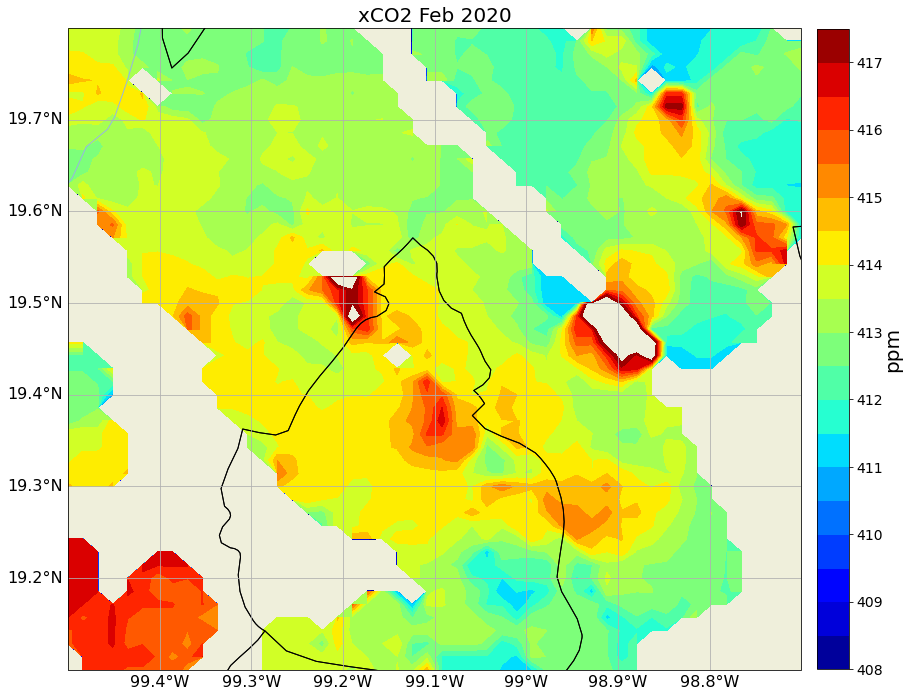

In [13]:
plt.figure(figsize=(14,14))
fontsize = 20
ticksize = 14
# Creates the map
mxmap = plt.axes(projection=ccrs.PlateCarree())

mxmap.add_feature(cfeature.LAND)
mxmap.add_feature(cfeature.OCEAN)
mxmap.add_feature(cfeature.COASTLINE)
mxmap.add_feature(cfeature.BORDERS, linestyle=':')
mxmap.add_feature(cfeature.LAKES, alpha=0.5)
mxmap.add_feature(cfeature.RIVERS)
mxmap.add_feature(cfeature.STATES.with_scale('10m'))
mxmap.set_extent((lonmin,lonmax,latmin,latmax))
#mxmap.xaxis.set_visible(True)
#mxmap.yaxis.set_visible(True)

glines = mxmap.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
glines.xformatter = LongitudeFormatter()
glines.yformatter = LatitudeFormatter()
glines.top_labels = None
glines.right_labels = None
glines.xlabel_style = {'size': 16}
glines.ylabel_style = {'size': 16}

lvls = np.arange(408,418,0.5)
plt.contourf(lons, lats, matrix, levels = lvls,cmap=plt.get_cmap("jet"),
             transform=ccrs.PlateCarree())
plt.title("xCO2 Feb 2020",size=fontsize)
plt.xlabel("Longitude",size=fontsize)
plt.ylabel("Latitude",size=fontsize)
cbar= plt.colorbar(fraction=0.041, pad=.02)
cbar.set_label("ppm", size=fontsize, labelpad=0.8)
cbar.ax.tick_params(labelsize=ticksize)
#plt.savefig('f:\\gitCCA\\cca-jupyter\\figures\\xco2_ml_feb-ago.png')
plt.show()

In [20]:
fh5.close()

NameError: name 'fh5' is not defined

In [52]:
fh5=h5py.File('test.h5','w')
dset=fh5.create_dataset('test',data=data,maxshape=(None,))
fh5.flush()
fh5.close()